In [449]:
%matplotlib inline
import numpy as np
import sklearn.neighbors
from sklearn.datasets.mldata import fetch_mldata
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import accuracy_score, confusion_matrix
import time
import re
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfTransformer

#MNIST

В данной части ноутбука приводится решение части задания, связанной с набором данных MNIST.

## Загрузка и визуализация данных

Загружаем набор данных mnist.

In [2]:
mnist = fetch_mldata("MNIST original")

Разбиваем на обучающую и тестовую выборки

In [3]:
y_train = mnist.target[:60000]
x_train = mnist.data[:60000, :]
y_test = mnist.target[60000:]
x_test = mnist.data[60000:, :]

Визуализируем по пять случайных объектов из обучающей выборки для каждого из десяти классов

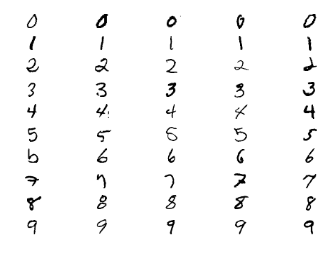

In [15]:
fig = plt.figure()
for j in range(10):
    x_j = x_train[y_train == j, :]
    for i in range(5):
        np.random.seed(i)
        a=fig.add_subplot(10, 5, 5 *j + i+1)
        plt.imshow(x_j[np.random.randint(x_j.shape[0], size=1), :].reshape((28, 28)), cmap="Greys")
        plt.axis("off")

## Сравнение точных алгоритмов KNN

### Собственная реализация KNN

Класс k_neigbour_classifier, реализует алгоритм классификации методом k ближайших соседей. Его конструктор принимает на вход функцию distance, возвращающую матрицу попарных расстояний между двумя выборками объектов, и число соседей num_neigbors.

Функция predict() получает на вход массивы train_x и train_y, состоящие из объектов обучающей выборки и соответствующих им меток классов, а также массив test_x, состоящий из объектов тестовой выборки. 

In [22]:
class  k_neighbour_classifier:
    def __init__(self, distance, num_neigbours):
        self.dist = distance
        self.k = num_neigbours
        
    def find_nearest_neighbors(self, train_x, test_x):
        distance_matrix = self.dist(test_x, train_x)
        args = np.argsort(distance_matrix, axis=1)[:, :self.k]
        return args
        
    def predict(self, train_x, train_y, test_x):
        """Returns predicted labels at test data points"""
        args = self.find_nearest_neighbors(train_x, test_x).flatten()
        y_indices_list = np.hstack([np.arange(test_x.shape[0])[:, None]] * self.k).ravel()
        labels_matrix = np.vstack([train_y]*test_x.shape[0])
        sorted_dist_labels_matrix = np.array(np.hsplit(labels_matrix[y_indices_list, args], test_x.shape[0]))
        return stats.mode(sorted_dist_labels_matrix, axis=1)[0].flatten()

Функция dist возвращает матрицу квадратов попарных евклидовых расстояний между двумя переданными ей матрицами x_1 и x_2.

In [70]:
def dist(x1, x2):
    x1_norm = np.linalg.norm(x1, axis=1)[:, None]
    x2_norm = np.linalg.norm(x2, axis=1)[None, :]
    return np.square(x1_norm) + np.square(x2_norm) - 2 * x1.dot(x2.T)

###Эксперименты

Проведем сравнение точных алгоритмов классификации методом KNN. Сравнение будем проводить по точности и по времени работы. Во всех экспериментах число соседей k = 5. При этом в каждом эксперименте случайным образом выбирается определенное число признаков, которые используются в методе KNN.

####10 случайных признаков

Выберем 10 случайных признаков

In [31]:
np.random.seed(10)
features = np.random.randint(x_train.shape[1], size=10)
while len(set(features)) != 10:
    features = np.array(list(set(features)))
    np.random.seed(i)
    i+=1
    features = np.append(features, np.random.randint(x_train.shape[1]))
x_train_ten = x_train[:, features]
x_test_ten = x_test[:, features]

#####Собственная реализация

In [71]:
knn = k_neighbour_classifier(dist, 5)
start_ten = time.time()
knn.find_nearest_neighbors(x_train_ten, x_test_ten)
finish_ten = time.time()

In [72]:
print("Собственная реализация KNN для 10 признаков работает", "%.2f" %(finish_ten - start_ten), "секунды.")

Собственная реализация KNN для 10 признаков работает 101.38 секунды.


#####Алгоритм brute

In [37]:
knn_brute = sklearn.neighbors.NearestNeighbors(n_neighbors=5, algorithm="brute")
start_brute_ten = time.time()
knn_brute.fit(x_train_ten)
knn_brute.kneighbors(x_test_ten)
finish_brute_ten = time.time()

In [38]:
print("brute-версия KNN для 10 признаков работает", "%.2f" %(finish_brute_ten - start_brute_ten), "секунды.")

brute-версия KNN для 10 признаков работает 18.88 секунды.


#####Алгоритм kd_tree

In [39]:
knn_kd = sklearn.neighbors.NearestNeighbors(n_neighbors=5, algorithm="kd_tree")
start_kd_ten = time.time()
knn_kd.fit(x_train_ten)
knn_kd.kneighbors(x_test_ten)
finish_kd_ten = time.time()

In [40]:
print("kd_tree-версия KNN для 10 признаков работает", "%.2f" %(finish_kd_ten - start_kd_ten), "секунды.")

kd_tree-версия KNN для 10 признаков работает 3.26 секунды.


#####Алгоритм ball_tree

In [41]:
knn_ball = sklearn.neighbors.NearestNeighbors(n_neighbors=5, algorithm="ball_tree")
start_ball_ten = time.time()
knn_ball.fit(x_train_ten)
knn_ball.kneighbors(x_test_ten)
finish_ball_ten = time.time()

In [42]:
print("ball_tree-версия KNN для 10 признаков работает", "%.2f" %(finish_ball_ten - start_ball_ten), "секунды.")

ball_tree-версия KNN для 10 признаков работает 7.46 секунды.


####20 случайных признаков

Выберем 20 случайных признаков

In [43]:
np.random.seed(20)
features = np.random.randint(x_train.shape[1], size=20)
i = 0
while len(set(features)) != 20:
    features = np.array(list(set(features)))
    np.random.seed(i)
    i+=1
    features = np.append(features, np.random.randint(x_train.shape[1]))
x_train_twenty = x_train[:, features]
x_test_twenty = x_test[:, features]

#####Собственная реализация

In [44]:
knn = k_neighbour_classifier(dist, 5)
start_twenty = time.time()
knn.find_nearest_neighbors(x_train_twenty, x_test_twenty)
finish_twenty = time.time()

In [45]:
print("Собственная KNN для 20 признаков работает", "%.2f" %(finish_twenty - start_twenty), "секунды.")

Собственная KNN для 20 признаков работает 98.74 секунды.


#####Алгоритм brute

In [46]:
knn_brute = sklearn.neighbors.NearestNeighbors(n_neighbors=5, algorithm="brute")
start_brute_twenty = time.time()
knn_brute.fit(x_train_twenty)
knn_brute.kneighbors(x_test_twenty)
finish_brute_twenty = time.time()

In [47]:
print("brute-версия KNN для 20 признаков работает", "%.2f" %(finish_brute_twenty - start_brute_twenty), "секунды.")

brute-версия KNN для 20 признаков работает 19.58 секунды.


#####Алгоритм kd_tree

In [48]:
knn_kd = sklearn.neighbors.NearestNeighbors(n_neighbors=5, algorithm="kd_tree")
start_kd_twenty = time.time()
knn_kd.fit(x_train_twenty)
knn_kd.kneighbors(x_test_twenty)
finish_kd_twenty = time.time()

In [49]:
print("kd_tree-версия KNN для 20 признаков работает", "%.2f" %(finish_kd_twenty - start_kd_twenty), "секунды.")

kd_tree-версия KNN для 20 признаков работает 9.10 секунды.


#####Алгоритм ball_tree

In [50]:
knn_ball = sklearn.neighbors.NearestNeighbors(n_neighbors=5, algorithm="ball_tree")
start_ball_twenty = time.time()
knn_ball.fit(x_train_twenty)
knn_ball.kneighbors(x_test_twenty)
finish_ball_twenty = time.time()

In [51]:
print("ball_tree-версия KNN для 20 признаков работает", "%.2f" %(finish_ball_twenty - start_ball_twenty), "секунды.")

ball_tree-версия KNN для 20 признаков работает 25.06 секунды.


####100 признаков


Выберем 100 случайных признаков

In [52]:
np.random.seed(100)
features = np.random.randint(x_train.shape[1], size=10)
while len(set(features)) != 100:
    features = np.array(list(set(features)))
    np.random.seed(i)
    i+=1
    features = np.append(features, np.random.randint(x_train.shape[1]))
x_train_hundred = x_train[:, features]
x_test_hundred = x_test[:, features]

#####Собственная реализация

In [53]:
knn = k_neighbour_classifier(dist, 5)
start_hundred = time.time()
knn.find_nearest_neighbors(x_train_hundred, x_test_hundred)
finish_hundred = time.time()

In [54]:
print("Собственная KNN для 100 признаков работает", "%.2f" %(finish_hundred - start_hundred), "секунды.")

Собственная KNN для 100 признаков работает 172.29 секунды.


#####Алгоритм brute

In [55]:
knn_brute = sklearn.neighbors.NearestNeighbors(n_neighbors=5, algorithm="brute")
start_brute_hundred = time.time()
knn_brute.fit(x_train_hundred)
knn_brute.kneighbors(x_test_hundred)
finish_brute_hundred = time.time()

In [56]:
print("brute-версия KNN для 100 признаков работает", "%.2f" %(finish_brute_hundred - start_brute_hundred), "секунды.")

brute-версия KNN для 100 признаков работает 20.84 секунды.


#####Алгоритм kd_tree

In [57]:
knn_kd = sklearn.neighbors.NearestNeighbors(n_neighbors=5, algorithm="kd_tree")
start_kd_hundred = time.time()
knn_kd.fit(x_train_hundred)
knn_kd.kneighbors(x_test_hundred)
finish_kd_hundred = time.time()

In [58]:
print("kd_tree-версия KNN для 100 признаков работает", "%.2f" %(finish_kd_hundred - start_kd_hundred), "секунды.")

kd_tree-версия KNN для 100 признаков работает 103.15 секунды.


#####Алгоритм ball_tree

In [59]:
knn_ball = sklearn.neighbors.NearestNeighbors(n_neighbors=5, algorithm="ball_tree")
start_ball_hundred = time.time()
knn_ball.fit(x_train_hundred)
knn_ball.kneighbors(x_test_hundred)
finish_ball_hundred = time.time()

In [60]:
print("ball_tree-версия KNN для 100 признаков работает", "%.2f" %(finish_ball_hundred - start_ball_hundred), "секунды.")

ball_tree-версия KNN для 100 признаков работает 138.95 секунды.


###Выводы

В случае, когда число признаков мало (около 10), алгоритмы kd_tree и ball_tree эффективны и существенно опережают brute-алгоритм по времени работы. При этом алгоритм kd_tree выигрывает у ball_tree. С ростом числа признаков оба метода начинают работать хуже. Уже при 20 признаках ball_tree работает примерно за то же время, за которое работает brute-алгоритм, а kd_tree все еще работает существенно быстрее. При большом числе признаков (около 100) brute алгоритм работает намного быстрее других алгоритмов. Моя реализация работает существенно медленнее стандартных, и лишь при большом числе признаков работает примерно за то же время, что и алгоритмы, основанные на построении деревьев.

##Кросс-Валидация

Функция cross_val_n_folds генерирует индексы, соответствующие элементам обучающей и валидационной выборки, для кросс-валидации с n фолдами. 

In [316]:
def cross_val_n_folds(n, train_set_size):
    fold_size = int(train_set_size/n)
    train_idx = [list(range(i * fold_size)) + list(range((i+1) * fold_size, train_set_size)) for i in range(n-1)] + \
                [list(range((n - 1) * fold_size))]
    test_idx = [list(range(i * fold_size, (i + 1) * fold_size)) for i in range(n-1)] + \
               [list(range((n - 1) * fold_size, train_set_size))]
    idx_arr = np.arange(train_set_size)
    np.random.seed(n)
    np.random.shuffle(idx_arr)
    return list(zip([idx_arr[idx] for idx in train_idx], [idx_arr[idx] for idx in test_idx]))

Реализуем оценку точности метода k ближайших соседей для нескольких значений k.

In [317]:
def cross_val_score(train_x, train_y, test_x, test_y, k_list, metrics):
    knn = sklearn.neighbors.NearestNeighbors(n_neighbors=k_list[-1], algorithm="brute", metric=metrics)
    knn.fit(train_x)
    _, indices = knn.kneighbors(test_x)
    test_number_list = sum([[i] * k_list[-1] for i in range(test_x.shape[0])], [])
    closest_labels = np.array(np.hsplit(np.vstack([train_y]*test_x.shape[0])[test_number_list, indices.ravel()], 
                                 test_x.shape[0]))
    accuracy_lst = []
    for k in k_list:
        k_closest_labels = closest_labels[:, :k]
        predicted_labels = stats.mode(k_closest_labels, axis=1)[0].flatten()
        accuracy_lst.append(accuracy_score(test_y, predicted_labels))
    return accuracy_lst

###Евклидова и косинусная метрики

Посчитаем точность классификации методом k ближайших соседей для $k = 1, \ldots, 10$ для евклидовой и косинусной метрики.

In [79]:
n_folds = 3
k_list = range(1, 11)
res_euc = np.zeros(len(k_list))
time_euc = 0
it = 1
for train_idx, test_idx in cross_val_n_folds(n_folds, x_train.shape[0]):
    print("Iteraion ", it, " / ", n_folds)
    train_set = np.copy(x_train[train_idx, :])
    train_labels = np.copy(y_train[train_idx])
    test_set = np.copy(x_train[test_idx, :])
    test_labels = np.copy(y_train[test_idx])
    it += 1
    start = time.time()
    res_euc += np.array(cross_val_score(train_set, train_labels, test_set, test_labels, k_list, 'euclidean'))
    finish = time.time()
    time_euc += finish - start
res_euc /= n_folds

Iteraion  1  /  3
Iteraion  2  /  3
Iteraion  3  /  3


In [83]:
print("Точность метода k ближайших соседей с евклидовой метрикой для различных k:")
for i in range(len(res_euc)):
    print("k =", i+1, ":", "%.4f"%res_euc[i])
print("Время работы кросс-валидации:", time_euc)

Точность метода k ближайших соседей с евклидовой метрикой для различных k:
k = 1 : 0.9695
k = 2 : 0.9619
k = 3 : 0.9691
k = 4 : 0.9674
k = 5 : 0.9684
k = 6 : 0.9666
k = 7 : 0.9667
k = 8 : 0.9654
k = 9 : 0.9651
k = 10 : 0.9643
Время работы кросс-валидации: 636.0866627693176


In [90]:
n_folds = 3
k_list = range(1, 11)
res_cos = np.zeros(len(k_list))
time_cos = 0
it = 1
for train_idx, test_idx in cross_val_n_folds(n_folds, x_train.shape[0]):
    print("Iteraion ", it, " / ", n_folds)
    train_set = np.copy(x_train[train_idx, :])
    train_labels = np.copy(y_train[train_idx])
    test_set = np.copy(x_train[test_idx, :])
    test_labels = np.copy(y_train[test_idx])
    it += 1
    start = time.time()
    res_cos += np.array(cross_val_score(train_set, train_labels, test_set, test_labels, k_list, 'cosine'))
    finish = time.time()
    time_cos += finish - start
res_cos /= n_folds

Iteraion  1  /  3
Iteraion  2  /  3
Iteraion  3  /  3


In [91]:
print("Точность метода k ближайших соседей с косинусной метрикой для различных k:")
for i in range(len(res_cos)):
    print("k =", i+1, ":", "%.4f"%res_cos[i])
print("Время работы кросс-валидации:", time_cos)

Точность метода k ближайших соседей с косинусной метрикой для различных k:
k = 1 : 0.9732
k = 2 : 0.9693
k = 3 : 0.9739
k = 4 : 0.9733
k = 5 : 0.9730
k = 6 : 0.9722
k = 7 : 0.9717
k = 8 : 0.9708
k = 9 : 0.9701
k = 10 : 0.9700
Время работы кросс-валидации: 877.7947187423706


Сравним Результаты

In [95]:
euclid_list = []
cos_list = []
i = 1
best_euc, k_euc = 0, 0
best_cos, k_cos = 0, 0
for result_euc, result_cos in list(zip(res_euc, res_cos)):
    if result_euc > result_cos:
        euclid_list.append(i)
    else:
        cos_list.append(i)
    if result_euc > best_euc:
        best_euc = result_euc
        k_euc = i
    if result_cos > best_cos:
        best_cos = result_cos
        k_cos = i
    i += 1
print("Евклидова метрика оказалась точнее для k = ", euclid_list, ",")
print("а косинусная — для k = ", cos_list, ".")
print("KNN с евклидовой метрикой показал лучшую точность", best_euc, " при k =", k_euc, ",")
print("а с косинусной метрикой — точность", best_cos, " при k =", k_cos, ".")

Евклидова метрика оказалась точнее для k =  [] ,
а косинусная — для k =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] .
KNN с евклидовой метрикой показал лучшую точность 0.9695  при k = 1 ,
а с косинусной метрикой — точность 0.97395  при k = 3 .


Таким образом, косинусная метрика дала лучшие значения на кросс-валидации для всех значений $k = 1, \ldots, 10$, но ее вычисление занимает почти в полтора раза больше времени.

###Взвешенный алгоритм k ближайших соседей

Опишем функцию, осуществляющую взвешенный метод k ближайших соседей. Голос каждого объекта равен $\frac{1} {distance + \varepsilon}$, где $distance$ — расстояние от классифицируемого объекта до данного объекта, а $\varepsilon = 10^{-5}$.

In [315]:
def weighted_knn_cross_val_score(train_x, train_y, test_x, test_y, k_list, metrics):
    eps = 1e-5
    knn = sklearn.neighbors.NearestNeighbors(n_neighbors=k_list[-1], algorithm="brute", metric=metrics)
    knn.fit(train_x)
    dists, indices = knn.kneighbors(test_x)
    scores = 1 / (dists + eps)
    test_number_list = sum([[i] * k_list[-1] for i in range(test_x.shape[0])], [])
    closest_labels = np.array(np.hsplit(np.vstack([train_y]*test_x.shape[0])[test_number_list, indices.ravel()], 
                                 test_x.shape[0]))
    accuracy_lst = []
    for k in k_list:
        k_closest_labels = closest_labels[:, :k]
        k_scores = scores[:, :k]
        class_scores = np.zeros((test_x.shape[0], 10))
        for i in range(10):
            class_scores[:, i] = np.sum(k_scores * (k_closest_labels == i).astype(int) , axis=1)
        predicted_labels = np.argmax(class_scores, axis=1)
        accuracy_lst.append(accuracy_score(test_y, predicted_labels))
    return accuracy_lst

###Евклидова и косинусная метрики для взвешенного метода k ближайших соседей

Посчитаем точность классификации взвешенным методом k ближайших соседей для $k = 1, \ldots, 10$ для евклидовой и косинусной метрики.

In [84]:
n_folds = 3
k_list = range(1, 11)
weighted_res_euc = np.zeros(len(k_list))
time_weuc = 0
it = 1
for train_idx, test_idx in cross_val_n_folds(n_folds, x_train.shape[0]):
    print("Iteraion ", it, " / ", n_folds)
    train_set = x_train[train_idx, :]
    train_labels = y_train[train_idx]
    test_set = x_train[test_idx, :]
    test_labels = y_train[test_idx]
    start = time.time()
    it += 1
    weighted_res_euc += np.array(weighted_knn_cross_val_score(train_set, train_labels, test_set, 
                                                 test_labels, k_list, 'euclidean'))
    finish = time.time()
    time_weuc += finish - start
weighted_res_euc /= n_folds

Iteraion  1  /  3
Iteraion  2  /  3
Iteraion  3  /  3


In [85]:
print("Точность взвешенного метода k ближайших соседей с евклидовой метрикой для различных k:")
for i in range(len(weighted_res_euc)):
    print("k =", i+1, ":", "%.4f"%weighted_res_euc[i])
print("Время работы кросс-валидации: ", time_weuc)

Точность взвешенного метода k ближайших соседей с евклидовой метрикой для различных k:
k = 1 : 0.9695
k = 2 : 0.9695
k = 3 : 0.9705
k = 4 : 0.9710
k = 5 : 0.9698
k = 6 : 0.9706
k = 7 : 0.9681
k = 8 : 0.9682
k = 9 : 0.9665
k = 10 : 0.9665
Время работы кросс-валидации:  644.8655979633331


In [104]:
weighted_list = []
non_weighted_list = []
i = 2
for result, weighted_result in list(zip(res_euc, weighted_res_euc))[1:]:
    if result_euc < weighted_result:
        weighted_list.append(i)
    elif result_euc > weighted_result:
        non_weighted_list.append(i)
    i += 1
print("Взвешенный метод с евклидовой метрикой оказался точнее точнее для k = ", weighted_list, ",")
print("а не взвешенный — для k = ", non_weighted_list, ".")

Взвешенный метод с евклидовой метрикой оказался точнее точнее для k =  [2, 3, 4, 5, 6, 7, 8, 9, 10] ,
а не взвешенный — для k =  [] .


In [96]:
n_folds = 3
k_list = range(1, 11)
weighted_res_cos = np.zeros(len(k_list))
time_wcos = 0
it = 1
for train_idx, test_idx in cross_val_n_folds(n_folds, x_train.shape[0]):
    print("Iteraion ", it, " / ", n_folds)
    train_set = x_train[train_idx, :]
    train_labels = y_train[train_idx]
    test_set = x_train[test_idx, :]
    test_labels = y_train[test_idx]
    start = time.time()
    it += 1
    weighted_res_cos += np.array(weighted_knn_cross_val_score(train_set, train_labels, test_set, 
                                                 test_labels, k_list, 'cosine'))
    finish = time.time()
    time_wcos += finish - start
weighted_res_cos /= n_folds

Iteraion  1  /  3
Iteraion  2  /  3
Iteraion  3  /  3


In [98]:
print("Точность взвешенного метода k ближайших соседей с косинусной метрикой для различных k:")
for i in range(len(weighted_res_cos)):
    print("k =", i+1, ":", "%.4f"%weighted_res_cos[i])
print("Время кросс-валидации: ", time_wcos)

Точность взвешенного метода k ближайших соседей с косинусной метрикой для различных k:
k = 1 : 0.9732
k = 2 : 0.9732
k = 3 : 0.9748
k = 4 : 0.9754
k = 5 : 0.9737
k = 6 : 0.9745
k = 7 : 0.9726
k = 8 : 0.9727
k = 9 : 0.9714
k = 10 : 0.9719
Время кросс-валидации:  842.8168520927429


In [105]:
weighted_list = []
non_weighted_list = []
i = 2
for result, weighted_result in list(zip(res_cos, weighted_res_cos))[1:]:
    if result < weighted_result:
        weighted_list.append(i)
    elif result > weighted_result:
        non_weighted_list.append(i)
    i += 1
print("Взвешенный метод с косинусной метрикой оказался точнее точнее для k = ", weighted_list, ",")
print("а не взвешенный — для k = ", non_weighted_list, ".")

Взвешенный метод с косинусной метрикой оказался точнее точнее для k =  [2, 3, 4, 5, 6, 7, 8, 9, 10] ,
а не взвешенный — для k =  [] .


Итак, взвешенный метод работает лучше не взвешенного для всех значений $k$. Сравним результаты взвешенного метода с косинусной и евклидовой метрикой.

In [108]:
euclid_list = []
cos_list = []
i = 1
best_euc, k_euc = 0, 0
best_cos, k_cos = 0, 0
for result_euc, result_cos in list(zip(weighted_res_euc, weighted_res_cos)):
    if result_euc > result_cos:
        euclid_list.append(i)
    else:
        cos_list.append(i)
    if result_euc > best_euc:
        best_euc = result_euc
        k_euc = i
    if result_cos > best_cos:
        best_cos = result_cos
        k_cos = i
    i += 1
print("Евклидова метрика оказалась точнее для k = ", euclid_list, ",")
print("а косинусная — для k = ", cos_list, ".")
print("Взвешенный KNN с евклидовой метрикой показал лучшую точность", best_euc, " при k =", k_euc, ",")
print("а с косинусной метрикой — точность", best_cos, " при k =", k_cos, ".")

Евклидова метрика оказалась точнее для k =  [] ,
а косинусная — для k =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] .
Взвешенный KNN с евклидовой метрикой показал лучшую точность 0.97105  при k = 4 ,
а с косинусной метрикой — точность 0.97535  при k = 4 .


Итак, лучшим оказался взвешенный KNN с косинусной метрикой и $k = 4$.

##Применение лучшего алгоритма к тестовой выборке

Напишем функцию weighted_knn_predict, возвращающую вектор предскзанных меток классов для тестовой выборки.

In [114]:
def weighted_knn_predict(train_x, train_y, test_x, k, metrics):
    eps = 1e-5
    knn = sklearn.neighbors.NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metrics)
    knn.fit(train_x)
    dists, indices = knn.kneighbors(test_x)
    scores = 1 / (dists + eps)
    test_number_list = sum([[i] * k for i in range(test_x.shape[0])], [])
    closest_labels = np.array(np.hsplit(np.vstack([train_y]*test_x.shape[0])[test_number_list, indices.ravel()], 
                                 test_x.shape[0]))
    class_scores = np.zeros((test_x.shape[0], 10))
    for i in range(10):
        class_scores[:, i] = np.sum(scores * (closest_labels == i).astype(int) , axis=1)
    predicted_labels = np.argmax(class_scores, axis=1)
    return predicted_labels

In [115]:
predicted_y_test = weighted_knn_predict(x_train, y_train, x_test, 4, 'cosine')

In [117]:
print("Точность метода на тестовой выборке: ", accuracy_score(y_test, predicted_y_test))


Точность метода на тестовой выборке:  0.9752


Полученная точность близка к точности, полученной на этапе кросс-валидации и к точности алгоритмов KNN, указанной в интернете. Точность лучших алгоритмов превышает 99%.

Выведем несколько картинок, на которых метод допустил ошибку

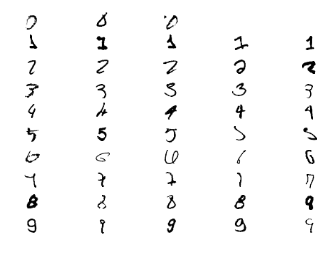

In [125]:
fig = plt.figure()
for j in range(10):
    x_j = x_test[np.logical_and(y_test == j, predicted_y_test != y_test), :]
    for i in range(min(5, x_j.shape[0])):
        a=fig.add_subplot(10, 5, 5 *j + i+1)
        plt.imshow(x_j[i].reshape((28, 28)), cmap="Greys")
        plt.axis("off")

Многие из картинок, на которых KNN допустил ошибку, похожи сразу на несколько цифр.

Матрица ошибок

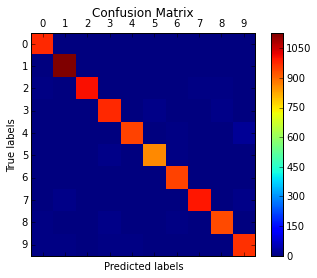

[[ 977    1    0    0    0    0    1    1    0    0]
 [   0 1129    3    1    0    0    2    0    0    0]
 [   8    0 1009    1    1    0    0    8    5    0]
 [   0    1    3  976    1   12    0    4    9    4]
 [   2    1    0    0  946    0    6    2    0   25]
 [   4    0    0    9    1  863    7    1    4    3]
 [   3    3    0    0    1    3  948    0    0    0]
 [   2   10    4    0    1    0    0  998    0   13]
 [   7    1    2    9    3    3    5    4  936    4]
 [   7    7    2    5    7    3    1    4    3  970]]


In [456]:
cm = confusion_matrix(y_test, predicted_y_test)
fig = plt.figure()
ax = fig.add_subplot(111)
cm_ax = ax.matshow(cm)
fig.colorbar(cm_ax)
plt.xticks(range(10))
plt.yticks(range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()
print(cm)

#20  News Groups

В этом разделе находится часть задания, относящаяся к набору данных 20newsgroups

##Загрузка и подготовка данных

Загружаем данные

In [195]:
train_news_groups = sklearn.datasets.fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))
test_news_groups = sklearn.datasets.fetch_20newsgroups(subset="test", remove=("headers", "footers", "quotes"))

In [196]:
train_data = train_news_groups.data
train_targets = train_news_groups.target
test_data = test_news_groups.data
test_targets = test_news_groups.target

Переведем все слова в нижний регистр

In [198]:
train_data = list(map(lambda s: s.lower(), train_data))
test_data = list(map(lambda s: s.lower(), test_data))

Заменим все символы, кроме букв и цифр на пробелы

In [199]:
train_data = list(map(lambda s: re.sub("[^a-z 0-9]",  " ", s), train_data))
test_data = list(map(lambda s: re.sub("[^a-z 0-9]",  " ", s), test_data))

Разобьем документы на термы.

In [200]:
test_data = list(map(lambda s: s.split(), test_data))
train_data = list(map(lambda s: s.split(), train_data))

Построим разреженную матрицу термов для обучающей выборки. Одновременно с этим мы получим словарь слов, входящих в обучающую выборку.

In [206]:
indptr, indices, data = [0], [], []
vocabulary = {}
for article in train_data:
    for word in article:
        index = vocabulary.setdefault(word, len(vocabulary))
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))
train_matr = csr_matrix((data, indices, indptr), dtype=float)

Теперь построим разреженную матрицу для тестовой выборки.

In [218]:
indptr, indices, data = [0], [], []
for article in test_data:
    for word in article:
        if word in vocabulary.keys():
            index = vocabulary[word]
            indices.append(index)
            data.append(1)
    indptr.append(len(indices))
test_matr = csr_matrix((data, indices, indptr), dtype=float, shape=(len(test_data), train_matr.shape[1]))

In [222]:
transformer = TfidfTransformer()
train_tfidf_matr = transformer.fit_transform(train_matr)
test_tfidf_matr = transformer.fit_transform(test_matr)

##Эксперименты

Перепишем функцию для оценки работы взвешенного метода k ближайших соседей, чтобы она могла работать с 20 метками классов.

In [313]:
def text_weighted_knn_cross_val_score(train_x, train_y, test_x, test_y, k_list, metrics):
    eps = 1e-5
    knn = sklearn.neighbors.NearestNeighbors(n_neighbors=k_list[-1], algorithm="brute", metric=metrics)
    knn.fit(train_x)
    dists, indices = knn.kneighbors(test_x)
    scores = 1 / (dists + eps)
    test_number_list = sum([[i] * k_list[-1] for i in range(test_x.shape[0])], [])
    closest_labels = np.array(np.hsplit(np.vstack([train_y]*test_x.shape[0])[test_number_list, indices.ravel()], 
                                 test_x.shape[0]))
    accuracy_lst = []
    for k in k_list:
        k_closest_labels = closest_labels[:, :k]
        k_scores = scores[:, :k]
        class_scores = np.zeros((test_x.shape[0], 20))
        for i in range(20):
            class_scores[:, i] = np.sum(k_scores * (k_closest_labels == i).astype(int) , axis=1)
        predicted_labels = np.argmax(class_scores, axis=1)
        accuracy_lst.append(accuracy_score(test_y, predicted_labels))
    return accuracy_lst

Сравним результаты работы невзвешенного KNN с евклидовой и косинусной метриками без применения tfidf.

Без tfidf:

In [318]:
n_folds = 3
k_list = range(1, 11)
text_res_euc = np.zeros(len(k_list))
text_res_cos = np.zeros(len(k_list))
text_res_weuc = np.zeros(len(k_list))
text_res_wcos = np.zeros(len(k_list))
text_time_euc, text_time_cos, text_time_weuc, text_time_wcos = 0, 0, 0, 0

it = 1
for train_idx, test_idx in cross_val_n_folds(n_folds, train_matr.shape[0]):
    print("Iteraion ", it, " / ", n_folds)
    train_set = train_matr[train_idx, :]
    train_labels = train_targets[train_idx]
    test_set = train_matr[test_idx, :]
    test_labels = train_targets[test_idx]
    it += 1
    
    start_euc = time.time()
    text_res_euc += np.array(cross_val_score(train_set, train_labels, test_set, test_labels, k_list, 'euclidean'))
    finish_euc = time.time()
    text_time_euc += finish_euc - start_euc
    
    start_cos = time.time()
    text_res_cos += np.array(cross_val_score(train_set, train_labels, test_set, test_labels, k_list, 'cosine'))
    finish_cos = time.time()
    text_time_cos += finish_cos - start_cos
    
    start_weuc = time.time()
    text_res_weuc += np.array(text_weighted_knn_cross_val_score(train_set, train_labels, test_set, test_labels, 
                                                           k_list, 'euclidean'))
    finish_weuc = time.time()
    text_time_weuc += finish_weuc - start_weuc
    
    start_wcos = time.time()
    text_res_wcos += np.array(text_weighted_knn_cross_val_score(train_set, train_labels, test_set, test_labels, 
                                                           k_list, 'cosine'))
    finish_wcos = time.time()
    text_time_wcos += finish_wcos - start_wcos

text_res_cos /= n_folds
text_res_euc /= n_folds
text_res_wcos /= n_folds
text_res_weuc /= n_folds

Iteraion  1  /  3
Iteraion  2  /  3
Iteraion  3  /  3


С tfidf:

In [325]:
n_folds = 3
k_list = range(1, 11)
tfidf_text_res_euc = np.zeros(len(k_list))
tfidf_text_res_cos = np.zeros(len(k_list))
tfidf_text_res_weuc = np.zeros(len(k_list))
tfidf_text_res_wcos = np.zeros(len(k_list))
tfidf_text_time_euc, tfidf_text_time_cos, tfidf_text_time_weuc, tfidf_text_time_wcos = 0, 0, 0, 0

it = 1
for train_idx, test_idx in cross_val_n_folds(n_folds, train_matr.shape[0]):
    print("Iteraion ", it, " / ", n_folds)
    train_set = train_tfidf_matr[train_idx, :]
    train_labels = train_targets[train_idx]
    test_set = train_tfidf_matr[test_idx, :]
    test_labels = train_targets[test_idx]
    it += 1
    
    start_euc = time.time()
    tfidf_text_res_euc += np.array(cross_val_score(train_set, train_labels, test_set, test_labels, k_list, 
                                                   'euclidean'))
    finish_euc = time.time()
    tfidf_text_time_euc += finish_euc - start_euc
    
    start_cos = time.time()
    tfidf_text_res_cos += np.array(cross_val_score(train_set, train_labels, test_set, test_labels, k_list, 'cosine'))
    finish_cos = time.time()
    tfidf_text_time_cos += finish_cos - start_cos
    
    start_weuc = time.time()
    tfidf_text_res_weuc += np.array(text_weighted_knn_cross_val_score(train_set, train_labels, test_set, test_labels, 
                                                           k_list, 'euclidean'))
    finish_weuc = time.time()
    tfidf_text_time_weuc += finish_weuc - start_weuc
    
    start_wcos = time.time()
    tfidf_text_res_wcos += np.array(text_weighted_knn_cross_val_score(train_set, train_labels, test_set, test_labels, 
                                                           k_list, 'cosine'))
    finish_wcos = time.time()
    tfidf_text_time_wcos += finish_wcos - start_wcos

tfidf_text_res_cos /= n_folds
tfidf_text_res_euc /= n_folds
tfidf_text_res_wcos /= n_folds
tfidf_text_res_weuc /= n_folds

Iteraion  1  /  3
Iteraion  2  /  3
Iteraion  3  /  3


##Анализ экспериментов

Результаты времени работы практически не отличаются для всех методов.

In [338]:
print("Время работы кросс-валидации без tf-idf:")
print("Невзвешенный knn, евклидова метрика: ", "%.2f"%text_time_euc)
print("Невзвешенный knn, косинусная метрика: ", "%.2f"%text_time_cos)
print("Взвешенный knn, евклидова метрика: ", "%.2f"%text_time_weuc)
print("Взвешенный knn, косинусная метрика: ", "%.2f"%text_time_wcos)
print()
print("Время работы кросс-валидации с использованием tf-idf:")
print("Невзвешенный knn, евклидова метрика: ", "%.2f"%tfidf_text_time_euc)
print("Невзвешенный knn, косинусная метрика: ", "%.2f"%tfidf_text_time_cos)
print("Взвешенный knn, евклидова метрика: ", "%.2f"%tfidf_text_time_weuc)
print("Взвешенный knn, косинусная метрика: ", "%.2f"%tfidf_text_time_wcos)

Время работы кросс-валидации без tf-idf:
Невзвешенный knn, евклидова метрика:  9.63
Невзвешенный knn, косинусная метрика:  9.35
Взвешенный knn, евклидова метрика:  8.78
Взвешенный knn, косинусная метрика:  9.97

Время работы кросс-валидации с использованием tf-idf:
Невзвешенный knn, евклидова метрика:  8.20
Невзвешенный knn, косинусная метрика:  7.93
Взвешенный knn, евклидова метрика:  8.54
Взвешенный knn, косинусная метрика:  8.29


###Анализ влияния факторов

In [327]:
if np.all(tfidf_text_res_euc < text_res_euc) and np.all(tfidf_text_res_weuc < text_res_weuc):
    print("Для всех значений k при использовании евклидовой метрики как для взвешенного, так и для обычного KNN", 
          "использование tf-idf приводит к ухудшению результата.")
improvement = -(np.mean(tfidf_text_res_euc - text_res_euc) + np.mean(tfidf_text_res_weuc - text_res_weuc)) / 2
print("Средняя прибавка точности при отказе от использования tf-idf для евклидовой метрики составляет ", 
      "%.1f"%(100 * improvement), "%.")

Для всех значений k при использовании евклидовой метрики как для взвешенного, так и для обычного KNN использование tf-idf приводит к ухудшению результата.
Средняя прибавка точности при отказе от использования tf-idf для евклидовой метрики составляет  9.5 %.


In [328]:
if np.all(tfidf_text_res_cos > text_res_cos) and np.all(tfidf_text_res_wcos > text_res_wcos):
    print("При этом для всех значений $k$ как для взвешенной, так и для не взвешенной версии метода с",
          "косинусной метрикой использование tf-idf приводит к улучшению результата.")
improvement = (np.mean(tfidf_text_res_cos - text_res_cos) + np.mean(tfidf_text_res_wcos - text_res_wcos)) / 2
print("Средняя прибавка точности при использовании tf-idf для косинусной метрики составляет ", 
      "%.1f"%(100 * improvement), "%.")

При этом для всех значений $k$ как для взвешенной, так и для не взвешенной версии метода с косинусной метрикой использование tf-idf приводит к улучшению результата.
Средняя прибавка точности при использовании tf-idf для косинусной метрики составляет  34.7 %.


In [329]:
if (np.all(tfidf_text_res_cos > tfidf_text_res_euc) and np.all(tfidf_text_res_wcos > tfidf_text_res_weuc)
    and np.all(text_res_cos > text_res_euc) and np.all(text_res_wcos > text_res_weuc)):
    print("При прочих равных использование косинусной метрики дает лучший результат, чем использование евклидовой.")
improvement = (np.mean(tfidf_text_res_cos - tfidf_text_res_euc) + np.mean(tfidf_text_res_wcos - tfidf_text_res_weuc)
              + np.mean(text_res_cos - text_res_euc) + np.mean(text_res_wcos - text_res_weuc))/4
print("Среднее прибавка точности при переходе от евклидовой метрики к косинусной составляет: ", 
     "%.1f"%(100*improvement), "%")
    

При прочих равных использование косинусной метрики дает лучший результат, чем использование евклидовой.
Среднее прибавка точности при переходе от евклидовой метрики к косинусной составляет:  28.3 %


In [336]:
if (np.all(tfidf_text_res_wcos >= tfidf_text_res_cos) and np.all(tfidf_text_res_weuc >= tfidf_text_res_euc)
    and np.all(text_res_wcos >= text_res_cos) and np.all(text_res_weuc >= text_res_euc)):
    print("При прочих равных взвешенный метод KNN дает лучший результат, чем обычный.")
improvement = (np.mean(tfidf_text_res_wcos - tfidf_text_res_cos) + np.mean(tfidf_text_res_weuc - tfidf_text_res_euc)
              + np.mean(text_res_wcos - text_res_cos) + np.mean(text_res_weuc - text_res_euc))/4
print("Среднее прибавка точности при переходе от невзвешанного метода к взвешенному составляет: ", 
     "%.1f"%(100*improvement), "%")

При прочих равных взвешенный метод KNN дает лучший результат, чем обычный.
Среднее прибавка точности при переходе от невзвешанного метода к взвешенному составляет:  2.2 %


Опишем функцию, вычисляющую по списку точностей для $k = 1, \ldots, 10$ оптимальное значение $k$ и точность на нем.

In [337]:
def find_opt_k(k_list, acc_list):
    max_acc, opt_k = 0, 0
    for k, acc in list(zip(k_list, acc_list)):
        if acc > max_acc:
            max_acc = acc
            opt_k = k
    return opt_k, max_acc

In [339]:
k_euc, acc_euc = find_opt_k(range(1, 11), text_res_euc)
k_cos, acc_cos = find_opt_k(range(1, 11), text_res_cos)
k_weuc, acc_weuc = find_opt_k(range(1, 11), text_res_weuc)
k_wcos, acc_wcos = find_opt_k(range(1, 11), text_res_wcos)
k_teuc, acc_teuc = find_opt_k(range(1, 11), tfidf_text_res_euc)
k_tcos, acc_tcos = find_opt_k(range(1, 11), tfidf_text_res_cos)
k_tweuc, acc_tweuc = find_opt_k(range(1, 11), tfidf_text_res_weuc)
k_twcos, acc_twcos = find_opt_k(range(1, 11), tfidf_text_res_wcos)

print("Оптимальные значения k и соответствующие точности для различных версий KNN:")
print("Без tf-idf:")
print("Невзвешенный knn, евклидова метрика: ", "%.3f"%acc_euc, "при k =", k_euc)
print("Невзвешенный knn, косинусная метрика: ", "%.3f"%acc_cos, "при k =", k_cos)
print("Взвешенный knn, евклидова метрика: ", "%.3f"%acc_weuc, "при k =", k_weuc)
print("Взвешенный knn, косинусная метрика: ", "%.3f"%acc_wcos, "при k =", k_wcos)
print()
print("С использованием tf-idf:")
print("Невзвешенный knn, евклидова метрика: ", "%.3f"%acc_teuc, "при k =", k_teuc)
print("Невзвешенный knn, косинусная метрика: ", "%.3f"%acc_tcos, "при k =", k_tcos)
print("Взвешенный knn, евклидова метрика: ", "%.3f"%acc_tweuc, "при k =", k_tweuc)
print("Взвешенный knn, косинусная метрика: ", "%.3f"%acc_twcos, "при k =", k_twcos)

Оптимальные значения k и соответствующие точности для различных версий KNN:
Без tf-idf:
Невзвешенный knn, евклидова метрика:  0.215 при k = 1
Невзвешенный knn, косинусная метрика:  0.283 при k = 1
Взвешенный knn, евклидова метрика:  0.217 при k = 5
Взвешенный knn, косинусная метрика:  0.283 при k = 1

С использованием tf-idf:
Невзвешенный knn, евклидова метрика:  0.142 при k = 1
Невзвешенный knn, косинусная метрика:  0.611 при k = 8
Взвешенный knn, евклидова метрика:  0.142 при k = 1
Взвешенный knn, косинусная метрика:  0.631 при k = 6


Построим график, показывающий зависимость точности от параметра $k$ для каждого из методов

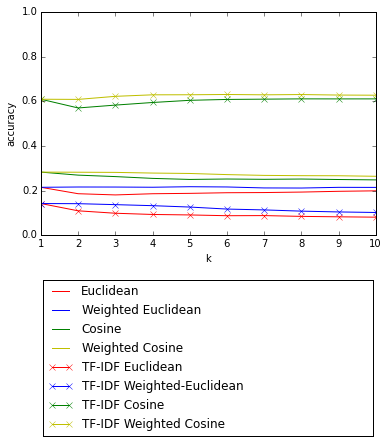

In [424]:
plt.plot(range(1, 11), text_res_euc, 'r', label="Euclidean")
plt.plot(range(1, 11), text_res_weuc, 'b', label="Weighted Euclidean")
plt.plot(range(1, 11), text_res_cos, 'g', label="Cosine")
plt.plot(range(1, 11), text_res_wcos, 'y', label="Weighted Cosine")
plt.plot(range(1, 11), tfidf_text_res_euc, '-rx', label="TF-IDF Euclidean")
plt.plot(range(1, 11), tfidf_text_res_weuc, '-bx', label="TF-IDF Weighted-Euclidean")
plt.plot(range(1, 11), tfidf_text_res_cos, '-gx', label="TF-IDF Cosine")
plt.plot(range(1, 11), tfidf_text_res_wcos, '-yx', label="TF-IDF Weighted Cosine")
plt.ylim(ymax=1, ymin=0)
plt.ylabel("accuracy")
plt.xlabel("k")
plt.legend(bbox_to_anchor=(0., -0.5, 1., -0.1), mode="expand", loc=10, borderaxespad=0.2)
plt.show()

Итак, лучшим вариантом метода KNN на кросс-валидации оказался взвешенный метод с использованием tf-idf и косинусной метрики при $k = 6$.

##Применение наилучшего алгоритма к тестовой выборке

Напишем функцию, предсказывающую значение меток класса на тестовой выборке с помощью взвешенного KNN с косинусной метрикой.

In [425]:
def text_weighted_knn_predict(train_x, train_y, test_x, k):
    eps = 1e-5
    knn = sklearn.neighbors.NearestNeighbors(n_neighbors=k, algorithm="brute", metric='cosine')
    knn.fit(train_x)
    dists, indices = knn.kneighbors(test_x)
    scores = 1 / (dists + eps)
    test_number_list = sum([[i] * k for i in range(test_x.shape[0])], [])
    closest_labels = np.array(np.hsplit(np.vstack([train_y]*test_x.shape[0])[test_number_list, indices.ravel()], 
                                 test_x.shape[0]))

    class_scores = np.zeros((test_x.shape[0], 20))
    for i in range(20):
        class_scores[:, i] = np.sum(scores * (closest_labels == i).astype(int) , axis=1)
    predicted_labels = np.argmax(class_scores, axis=1)
    return predicted_labels

Вычислим прогноз для меток на тестовой выборке.

In [428]:
predicted_labels = text_weighted_knn_predict(train_tfidf_matr, train_targets, test_tfidf_matr, 6)

In [429]:
print("Точность прогноза: ", accuracy_score(test_targets, predicted_labels))

Точность прогноза:  0.561869357408


Полученная точность хуже точности на кросс-валидации, но не слишком далека от нее.

Несколько документов, на которых были допущены ошибки

In [463]:
mistaken_docs = np.array(test_news_groups.data)[test_targets != predicted_labels]
for i in np.random.randint(mistaken_docs.size, size=10):
    print("Article", i)
    print("True label: ", list(train_news_groups.target_names)[(test_targets[test_targets != predicted_labels])[i]])
    print("Predicted label: ", list(train_news_groups.target_names)
          [(predicted_labels[test_targets != predicted_labels])[i]])
    print(mistaken_docs[i])

Article 645
True label:  comp.graphics
Predicted label:  comp.windows.x
What I'd like to see is the more generic N-dimensional widget set.
I realize, that there wouldn't be a whole shitload of people
who'd want more than 3, but why stop?

All I need is a Widget with up to N viewports showing me different
3-D or 2-D slices of my stuff.

alter,
pat

Article 2466
True label:  rec.sport.hockey
Predicted label:  talk.politics.mideast

This would be dumb move of the nineties...Lindros is big and strong...
but why give him a ball and chain on one leg and an anchor on the
other to drag along.


Not if Pocklington gets there first! (-...actually, if Pocklington
doesn't get a better deal, he would probably go to Hamilton...taking
the team out of Canada would get the whole country mad at him...
taking the team to Hamilton wouldn't get anybody mad at him that 
isn't mad at him already...and would make him a lot of friends
in Southern Ontario...so many that the whining of the stupid politicians in


Во многих текстах, на которых были допущены ошибки, встречаются слова, указывающие на принадлежность их к категории, к которой их отнес KNN.

Матрица ошибок

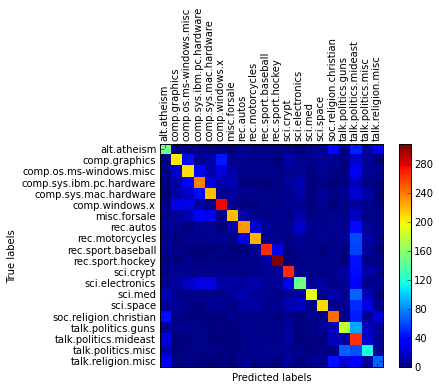

In [467]:
cm = confusion_matrix(test_targets, predicted_labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cm_ax = ax.matshow(cm)
fig.colorbar(cm_ax)
plt.xticks(range(20), list(train_news_groups.target_names), rotation='vertical')
plt.yticks(range(20), list(train_news_groups.target_names))
# plt.title("Confusion Matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()


Видно, что алгоритм достаточно часто неверно интерпретировал статьи, как относящиеся к теме politics.mideast. В остальном чаще всего он ошибается в близких темах.

##Выводы

Во всех проведенных экспериментах взвешенный метод оказался лучше невзвешанного, а косинусная метрика — лучше евклидовой. Зависимость от числа соседей в диапазоне $1, \ldots, 10$ не слишком велика. На наборе данных mnist разница между всеми вариантами алгоритма по точности не слишком велика. При этом метод с евклидовой метрикой работает почти в полтора раза быстрее, поэтому в случае, когда достаточно хорошей, но не оптимальной точности, следует использовать евклидову метрику. В задаче классификации текстов использование преобразования tf-idf дает очень серьезную прибавку в точности.

В целом, KNN очень хорошо работает на наборе данных mnist и не так хорошо на задаче классификации текстов. Не лучшее качество классификации во втором случае объясняется тем, что многие из рассматриваемых тем близки, и различить их по используемым словам не всегда возможно.